# Exploratory Analysis

> Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.
>
> -- [Prasad Patil, Novice Data Science Storyteller, Mar 23](https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15)

**Goals of exploration**

- Can we see patterns, find signals in the data? 

- What features are driving the outcome?

- Are there other features we can construct that have stronger relationships? 

- Use Visualization and statistical testing to help answer these questions. 

- We want to walk away from exploration with with modeling strategies (feature selection, algorithm selection, evaluation methods, for example).  

**Agenda**

- Wrangle data (acquire, prep, summarize, split)

- Identify questions to answer, hypotheses to test. 

- 

**Sample Scenario**

We would like to be able to use attributes of customers to estimate their spending score.
In doing so, we can target those customers that are likely to be most profitable for us. 
Our target variable is spending_score. 
Currently the only customer data we have available to use in this project is age, annual_income and gender. 
It is possible we may not have enough information to build a valuable model. If not, maybe we could do some unsupervised learning, and find clusters of similar customers using all of the variables (including spending_score) and that could help us with a starting point for our targeted marketing. 

## Wrangle Data 

We will use the mall customer data in this lesson. 

**Prepare Environment**

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve

pd.options.display.float_format = '{:20,.2f}'.format

**Acquire**

Acquire Mall Customer data from our SQL database using the acquire helper function we created. 

Acquire.py: 

```python
import pandas as pd
import env

def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

def get_mallcustomer_data():
    url = get_connection('mall_customers')
    df = pd.read_sql('SELECT * FROM customers', url)
    return df.set_index('customer_id')
```

In [2]:
import acquire

# read the data into df
df = acquire.get_mallcustomer_data()

In [3]:
df.head()

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [4]:
# create dummy vars of 'gender' column, drop the first dummy var and keep remaining. 
# In testing, I see there is one dummy var returned, 'Male', so I 
# create a new column in our df, 'is_male', to hold the values for the new dummy var. 

df['is_male'] = pd.get_dummies(df['gender'], drop_first=True)['Male']
df.drop(columns=['gender'], inplace=True)
df.head()

,age,annual_income,spending_score,is_male
customer_id,,,,
1,19,15,39,True
2,21,15,81,True
3,20,16,6,False
4,23,16,77,False
5,31,17,40,False


**Summarize**

Is the data ready to explore? 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             200 non-null    int64
 1   annual_income   200 non-null    int64
 2   spending_score  200 non-null    int64
 3   is_male         200 non-null    bool 
dtypes: bool(1), int64(3)
memory usage: 6.4 KB


In [6]:
df.describe()

,age,annual_income,spending_score
count,200.00,200.00,200.00
mean,38.85,60.56,50.20
std,13.97,26.26,25.82
min,18.00,15.00,1.00
25%,28.75,41.50,34.75
50%,36.00,61.50,50.00
75%,49.00,78.00,73.00
max,70.00,137.00,99.00


We have no missing values, all numeric data, outliers aren't too extreme...our data is ready to split and then explore. 

**train validate test split**

In [7]:
# split test off, 20% of original df size. 
train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=42)

# split validate off, 30% of what remains (24% of original df size)
# thus train will be 56% of original df size. 
train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=42)

print("train observations: ", train.size)
print("validate observations: ", validate.size)
print("test observations: ", test.size)

train observations:  448
validate observations:  192
test observations:  160


*We are not going to explore the scaled data at this time, but it is important that the data is scaled before moving into clustering.*

## Explore

1. Ask questions.

2. Answer questions via visualizations and statistical tests. 

3. Summarize. 

Tips to remember when visualizing for exploration (as opposed to visualizing for reporting or storytelling): 

- Charts are many and are quickly made.

- Axis and labels are cleaned up later.

- Color and size are used for information, not aesthetics.

- Chart types include box plots, heatmaps, histograms, density plots, and feature or correlation plots.

- Title are useful!

### Ask Questions

**Target Variable:** spending_score

Questions to answer &/or hypotheses to test: 

1. What is the distribution of each of the variables? This is important as we move forward into testing and modeling. 

1. Does the spending score differ across gender? 

2. Is there a relationship between spending score and annual income? (Linear or otherwise). 

3. Is there a relationship between age and spending score? (Linear or otherwise). 

4. If we control for age (by decade), does spending score differ across annual income? 

5. If we control for annual income, does spending score differ across age decades? 

### Answer Questions

**1. What is the distribution of each of the variables?**

This is important as we move forward into testing and modeling.

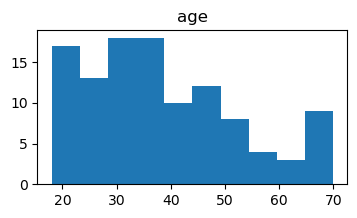

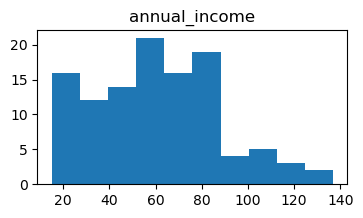

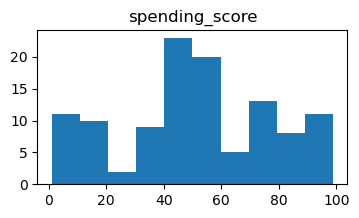

In [8]:
for col in train.drop(columns='is_male').columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

**Conclusion:**

- spending_score is normally distributed. 

- Age and annual_income are skewed right. I will want to use spearman's correlation test when testing the linear relationships due to the skew. 

- The sample has slightly fewer males.  

- If I make bins, then I might want to bin 90k+ for annual salary and 50+ for age. 

_________________________________________________

**2. Does spending_score differ across gender**

1. Plot gender vs. spending score

2. 2-sample, 2-tailed t-test comparing the mean spending_score male vs. not male. (I would need to test the assumption of equal variance) 

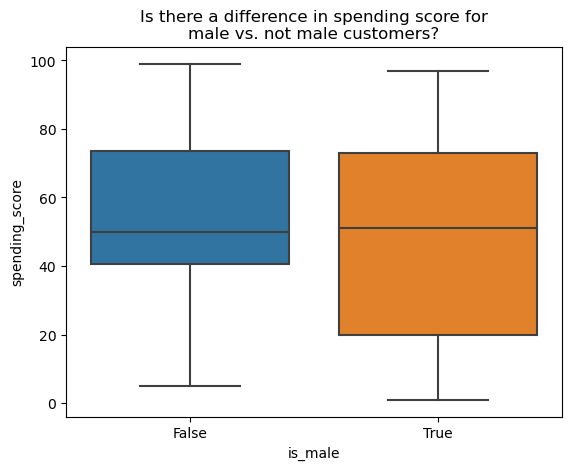

In [9]:
sns.boxplot(x=train.is_male, y=train.spending_score)
plt.title("Is there a difference in spending score for\nmale vs. not male customers?")
plt.show()

There is clearly not a difference in mean, but let's run a test for practice. 

- We have 2 groups and want to compare a continuous variable => independent (2-sample) t-test. 

- Our 2 groups: is_male==0 and is_male==1

- Our continuous variable: spending_score. 

- Null hypothesis: $H_{0}: \mu_{is\_male==0} = \mu_{is\_male==1}$

- Test the assumption of equal variance of spending score for the 2 groups using **Levene's Test**. As in other tests, the null hypothesis is the one that assumes equality, i.e. the variance of spending score for the non-male group == variance of spending score for the male group. If p-value > .05, we can say that the variances are not significantly different and set the argument in ttest_ind of equal_var to be True. If p-value < .05, we say the variances are NOT equal and set equal_var to be False. 

In [10]:
# test the equal variance 
# H0 is that the variances are equal
# Levene test
# our two groups are 1) where train.is_male==0 and 
# 2) where train.is_male == 1

stats.levene(train[train.is_male==0].spending_score, 
             train[train.is_male==1].spending_score)

LeveneResult(statistic=1.52123656007133, pvalue=0.22006154667448222)

In [11]:
stats.ttest_ind(train[train.is_male==0].spending_score, 
                train[train.is_male==1].spending_score, 
                equal_var=True
               )

Ttest_indResult(statistic=0.7973640087804729, pvalue=0.4269574825618323)

**Conclusion:** There is not a difference in mean spending scoreacross gender; however, it does appear that non-male customers sit a bit higher than the male customers, as evidenced by the 3rd quartile sitting at 40 vs 20 for male customers. 

__________________________

**3. Is there a relationship between spending score and annual income? (Linear or otherwise).**

1. Plot annual_income by spending_score

2. If there appears to be some linear correlation, then run spearman's test for linear correlation. We would run spearman's instead of pearson's because both variables are not normally distributed (annual_income, in this case). 

Is there a relationship
between annual income and spending score?


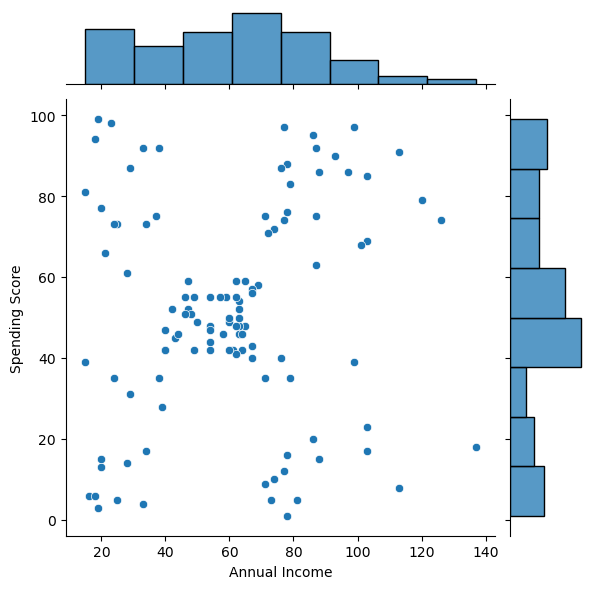

In [12]:
print("Is there a relationship\nbetween annual income and spending score?")
sns.jointplot(x="annual_income", y="spending_score", data=train)
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.show()

**Conclusion:** There is not a linear relationship between annual_income and spending_score, but there appears to be a relationship shaped somewhat like an x. It makes me think that another variable is interacting leading to the highs and lows on the X. My guess is age is interacting. 

__________________________

**4. Is there a relationship between age and spending score?**

1. Plot age by spending_score. 

2. Linear Relationship? If there appears to be something, I can run a spearman's test to confirm. (Spearman because age is not normally distributed. If it was, I would use a pearson's test.)

3. Create groups of ages and compare mean spending score using t-test and plotting. 

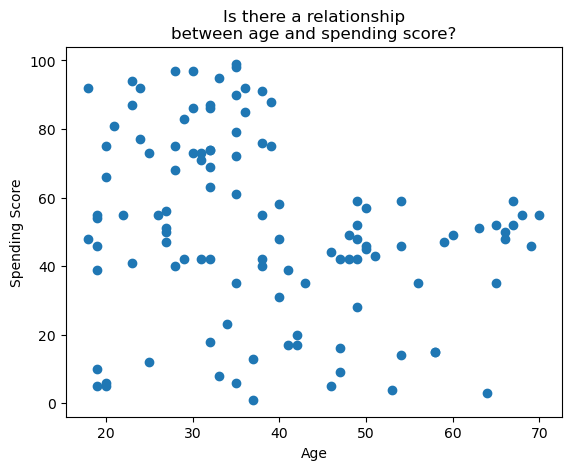

In [13]:
# plot age by spending_score
plt.scatter(train.age, train.spending_score)
plt.xlabel("Age")
plt.ylabel("Spending Score")
plt.title("Is there a relationship\nbetween age and spending score?")
plt.show()

It appears that after 40 or so, max spending score drops. (range is limited to < 60 +/-)
If I bin the age \[0, 40\], (40, 80\], will there be a significant difference in spending score? 

In [14]:
# create age bins for < 40 and >= 40 
train['age_bin'] = pd.cut(train.age, [0,40, 80])

train.head()

,age,annual_income,spending_score,is_male,age_bin
customer_id,,,,,
131,47,71,9,True,"(40, 80]"
63,67,47,52,False,"(40, 80]"
14,24,20,77,False,"(0, 40]"
174,36,87,92,True,"(0, 40]"
145,25,77,12,True,"(0, 40]"


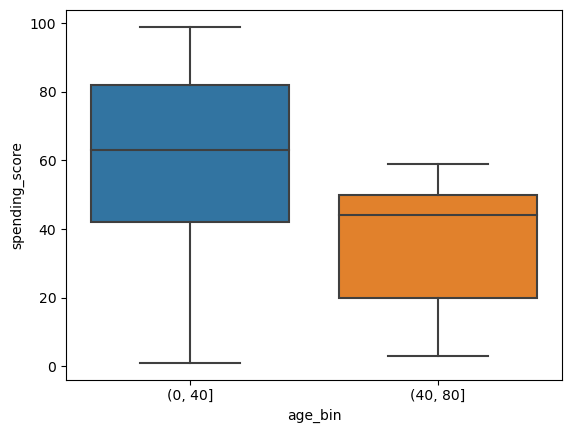

In [15]:
# box plot of the two groups and spending score
sns.boxplot(x=train.age_bin, y=train.spending_score)
plt.show()

There is definitely a difference between these two groups. 
I will run a two-sample, two-tailed t-test just to confirm the sample sizes aren't leading us to make false assumptions. It is clear the variances between the two groups is different, but let's run a test for practice. 

In [16]:
# test the assumption of equal variance

stats.levene(train[train.age <= 40].spending_score, 
             train[train.age > 40].spending_score
            )

LeveneResult(statistic=11.809551017293076, pvalue=0.0008325687159373646)

Variances are unequal, p-value < 0.05. 

In [17]:
# variances are unequal
# t-test, 2-sample (independent), 2-tail. 

stats.ttest_ind(train[train.age <= 40].spending_score, 
                train[train.age > 40].spending_score,
                equal_var=False
               )

Ttest_indResult(statistic=5.011777953183408, pvalue=2.087595446622472e-06)

**Conclusion:** While there is not a linear relationship, there is a significant difference in spending score for ages < 40 vs those >= 40. 

________________________

**5. If we control for age, does spending score differ across annual income?**


1. Let's start by plotting annual income by spending score for each of the age bins created. 

2. Analyze each bin separately. For those <=40, is there a relationship between income and spending score? For those > 40, is there a relationship? *If we look at the plot that was shaped like an x (income vs spending) with only the customers <= 40, will the shape change?*

3. If a test is necessary, run a test. 

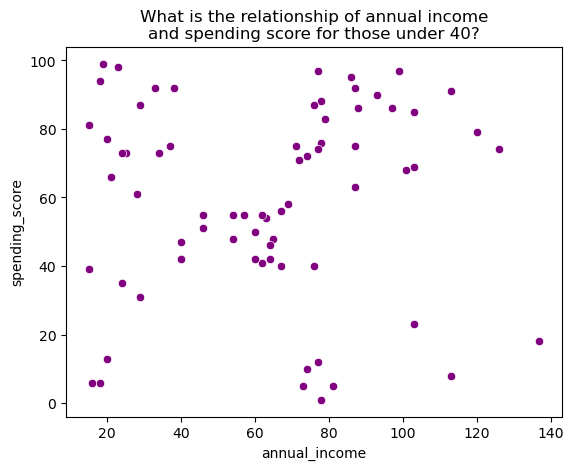

In [18]:
sns.scatterplot(x='annual_income', y='spending_score', 
                data=train[train.age <= 40], 
                color='purple'
               )

plt.title("What is the relationship of annual income\nand spending score for those under 40?")
plt.show()

It still maintains the x-shape, maybe a little more on the upper parts of the x. 

Let's look at those > 40.

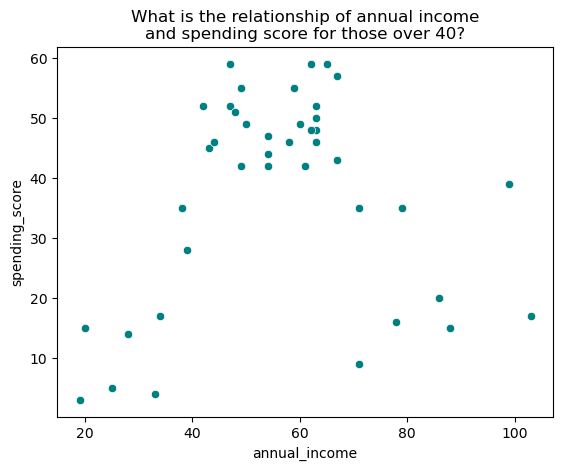

In [19]:
sns.scatterplot(x='annual_income', y='spending_score',
                data=train[train.age > 40],
                color='teal'
               )
plt.title("What is the relationship of annual income\nand spending score for those over 40?")
plt.show()

For those <= 40, there still seems to be some in the lower part of the x, it still maintains the shape of the x somewhat, but definitely tending more toward the upper corners. This makes me wonder if there is difference within the 20's vs. 30's. 

For those > 40, they are all sitting on the lower half of the x, making a quadratic shape. 

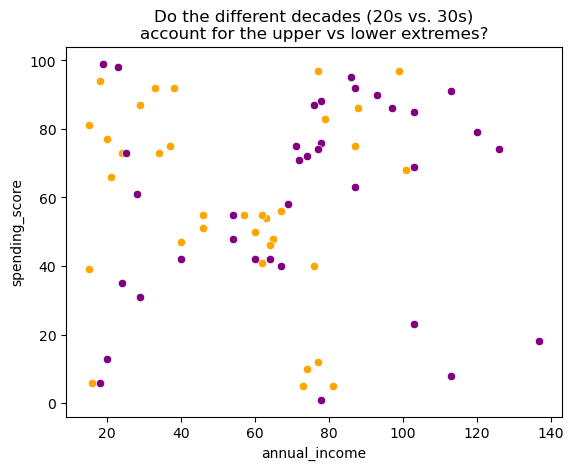

In [20]:
sns.scatterplot(x='annual_income', y='spending_score',
                data=train[train.age<=30], color='orange')

sns.scatterplot(x='annual_income', y='spending_score',
                data=train[(train.age>30) & (train.age<=40)], 
                color='purple')

plt.title("Do the different decades (20s vs. 30s)\naccount for the upper vs lower extremes?")
plt.show()

The different decades do not seem to be driving the difference on the corners of the x. 
Maybe I will check if gender has anything to do with the difference. If not, I will take my learnings and run! 
But before then, conclusions: 

**Conclusion:**

- For those < 40, annual income and spending score still maintain the shape of the x somewhat, but definitely tending more toward the upper corners. This does not clear up when separating between 20's and 30's. 

- For those >= 40, they are all sitting on the lower half of the x, making a quadratic shape opening downward. 

_____________________________

**5b. Does gender explain the high income-low spending score and/or low income-low spending score in the under 40 group?**

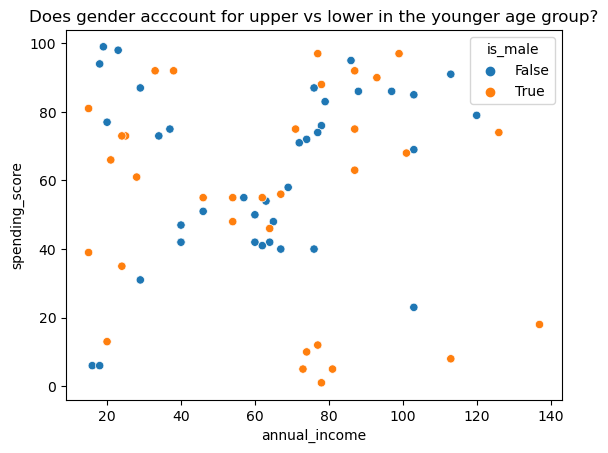

In [21]:
sns.scatterplot(x='annual_income', y='spending_score',
               data=train[train.age <= 40], hue='is_male')

plt.title("Does gender acccount for upper vs lower in the younger age group?")
plt.show()

**Conclusion:** It's possible gender could be the difference here, but I'm not sure if there is enough evidence to conclude that. It appears that non-males under 40 have a quadratic curve that opens up and has a minimum at annual income between 40 and 60. It appears that males under 40 go both up and down on the extremities (still have the x-shape). 

________________________

**6. If we control for annual income, does spending score differ across age?**

Because of the shape of annual income with spending score, I will create 3 bins of income: \[0, 40), \[40, 70), \[70, 140\]. 

In [22]:
# bin income into 3 bins

train['income_bin'] = pd.cut(train.annual_income, [0, 40, 70, 140])

In [23]:
train.head()

,age,annual_income,spending_score,is_male,age_bin,income_bin
customer_id,,,,,,
131,47,71,9,True,"(40, 80]","(70, 140]"
63,67,47,52,False,"(40, 80]","(40, 70]"
14,24,20,77,False,"(0, 40]","(0, 40]"
174,36,87,92,True,"(0, 40]","(70, 140]"
145,25,77,12,True,"(0, 40]","(70, 140]"


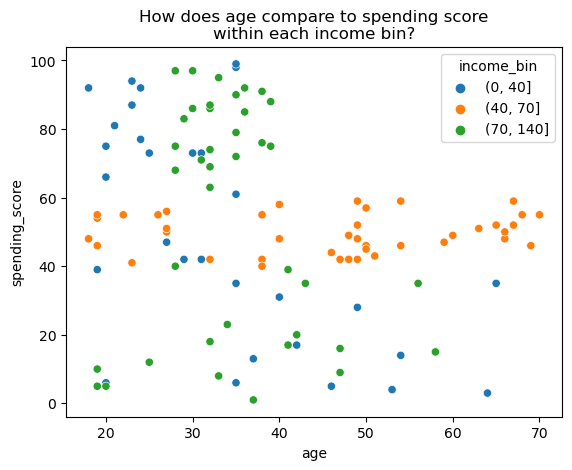

In [24]:
sns.scatterplot(x='age', y='spending_score',
               data=train, hue='income_bin')
plt.title("How does age compare to spending score\nwithin each income bin?")
plt.show()

The middle income bin maintains the same spending score regardless of age. While the other two income bins maintain the original relationship of age to spending score (where the spending score drops after age 40). 

**Conclusion:**

There appears to be no difference in spending score for lower income vs. higher income...it appears that all the difference that exists is due to age. 
We could either just do two bins for income (mid vs. high/low) or we could 3 and see what happens. 
Using the binned age as a feature instead of continuous age, and using binned income instead of continuous income. 

### Summarize Findings

**Final Conclusion, Next Steps**

- maybe try to build clusters with the annual_income
- use the 2 age bins (0,41], (41,)
- Use income bins 
- keep gender to see if it adds value. 

### Plots for a broad view

Sometimes you don't know what to ask, or want to make sure you got all the obvious stuff. These plots can give you a nice glimpse into all your variables. 

Be careful! Pairplots can take a LONNNNNG time to run if you have a lot of variables. 


Interaction of variables along with younger vs older
(cutoff=40)


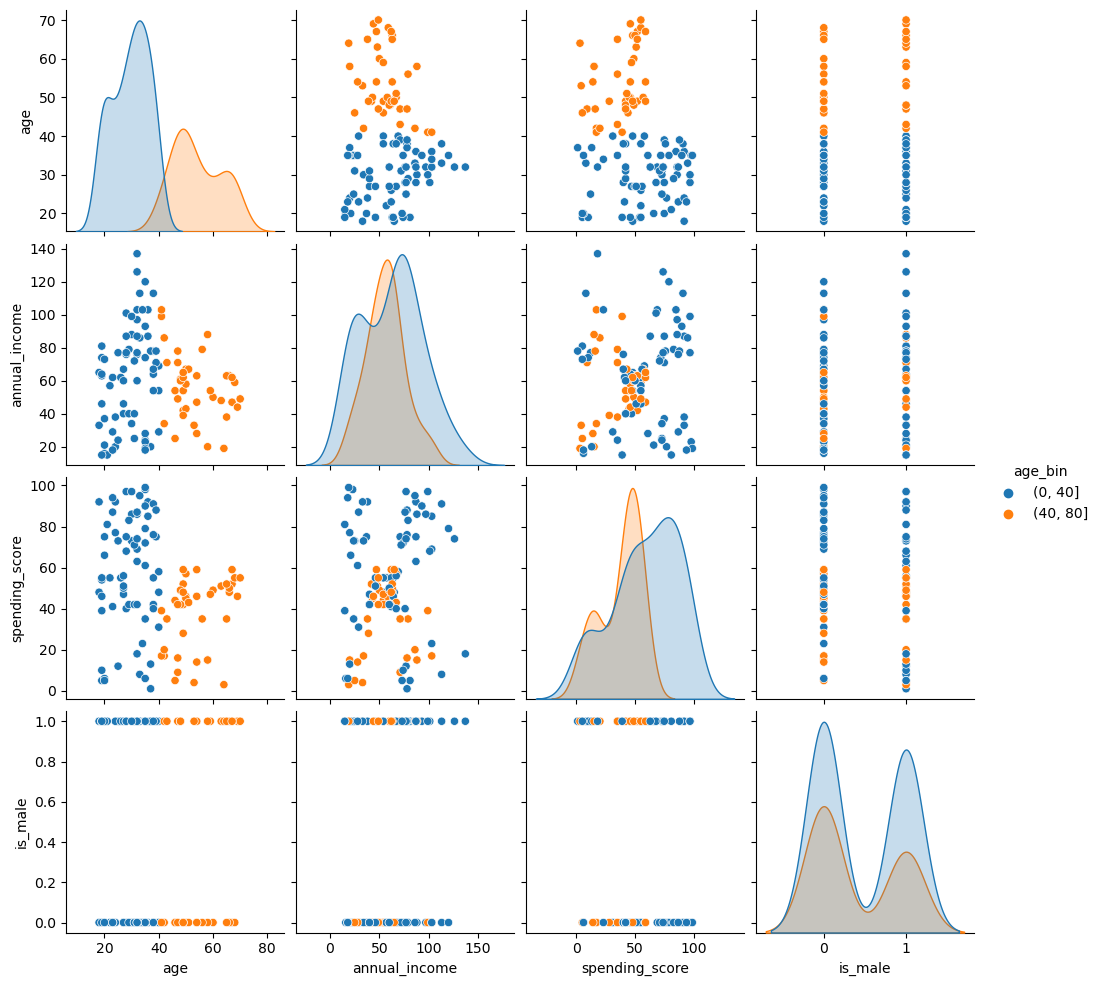

In [25]:
print("Interaction of variables along with younger vs older\n(cutoff=40)")
sns.pairplot(train, hue='age_bin')
plt.show()

Interaction of variables along with income bins


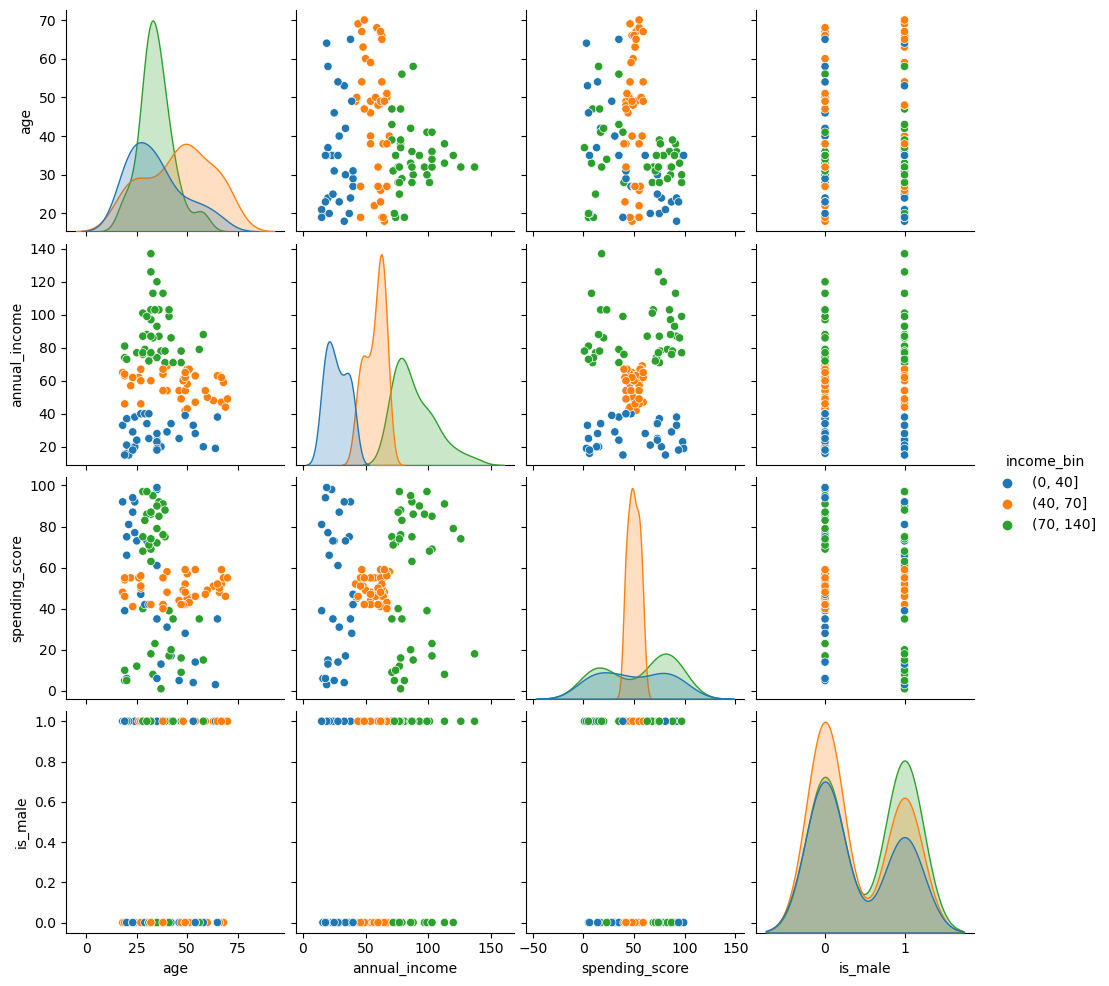

In [26]:
print("Interaction of variables along with income bins")
sns.pairplot(train, hue='income_bin')
plt.show()

Interaction of variables along with gender


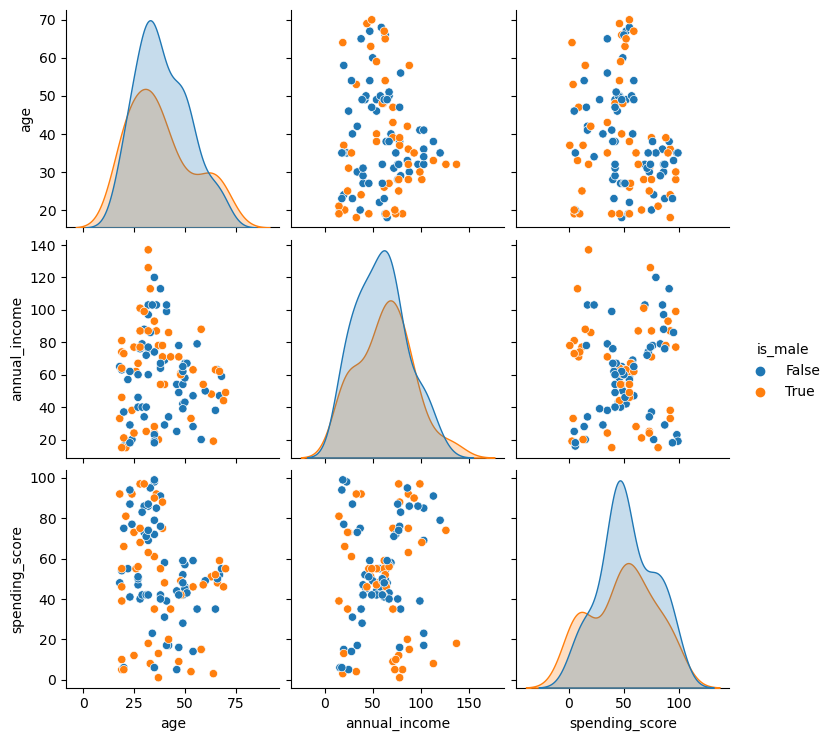

In [27]:
print("Interaction of variables along with gender")
sns.pairplot(train, hue='is_male')
plt.show()

A look at all continuous variables for each (i.e. grouped by) class of gender. 

In [29]:
train.head()

,age,annual_income,spending_score,is_male,age_bin,income_bin
customer_id,,,,,,
131,47,71,9,True,"(40, 80]","(70, 140]"
63,67,47,52,False,"(40, 80]","(40, 70]"
14,24,20,77,False,"(0, 40]","(0, 40]"
174,36,87,92,True,"(0, 40]","(70, 140]"
145,25,77,12,True,"(0, 40]","(70, 140]"


<Axes: xlabel='is_male'>

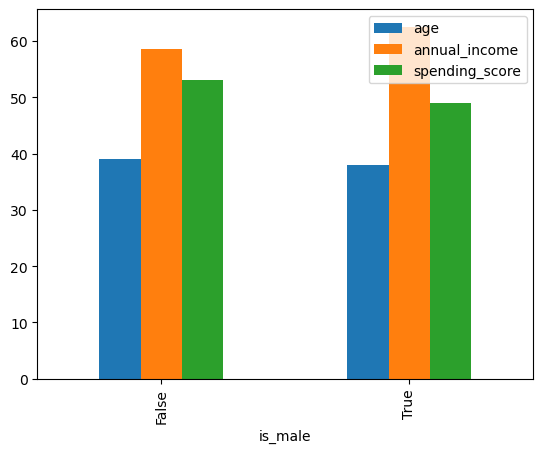

In [31]:
train.drop(columns=['age_bin', 'income_bin']).groupby('is_male').mean().plot.bar()

## Further Reading

- [Seaborn Color Palettes](http://seaborn.pydata.org/tutorial/color_palettes.html)


## Exercises

Sourcing the Zillow database as the data source, create a jupyter notebook named `explore_zillow` and do the following:

1. Ask at least 5 questions about the data, keeping in mind that your target variable is logerror. e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County? 

1. Answer those questions through a mix of statistical tests and visualizations. 


Bonus:

Compute the mean(logerror) by zipcode and the overall mean(logerror). Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error. 
